In [ ]:
import sys

sys.path.append("..")

import os

project_root = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))

import pandas as pd
from training import TrainingManager, TrainingConfig
from envs.trading_env import MyTradingEnv

N_EPISODES=20_000

MAX_STEPS=1000
LEARNING_RATE=0.05
DISCOUNT_FACTOR=0.9
EPSILON_START=1.0
EPSILON_END=0.01
EPSILON_DECAY=0.9995
EVAL_FREQUANCY=500
SAVE_FREQUANCY=1_000

TRAIN_VERSION="v3"

data_path = "../data/data_1h_2023.csv"
df1 = pd.read_csv(data_path, index_col=0, parse_dates=True, date_format="iso8601")

data_path = "../data/data_1h_2024.csv"
df2 = pd.read_csv(data_path, index_col=0, parse_dates=True, date_format="iso8601")

df = pd.concat([df1, df2])

INITIAL_BALANCE = 1000.0
WINDOW_SIZE = 10
COMMISSION = 0.0001
SLIPPAGE = 0.0005
MAX_HOLDING_TIME = 60 * 24
HOLDING_THRESHOLD = 24
MAX_DRAWDOWN_THRESHOLD = 0.05
LAMBDA_DRAWDOWN = 0.1 # напрада в процентах
LAMBDA_HOLD = 0.025 # напрада в процентах
REWARD_SCALING=100.0 # напрада в процентах

### Обучение QLearningAgent

In [ ]:

from agents.classical.qlearning_agent import QLearningAgent

agent = QLearningAgent()
env = MyTradingEnv(
    df=df,
    initial_balance=INITIAL_BALANCE,
    window_size=WINDOW_SIZE,
    commission=COMMISSION,
    slippage=SLIPPAGE,
    max_holding_time=MAX_HOLDING_TIME,
    lambda_drawdown=LAMBDA_DRAWDOWN,
    lambda_hold=LAMBDA_HOLD,
    reward_scaling=REWARD_SCALING,
)

config = TrainingConfig(
    agent_name=f"QLearning_{TRAIN_VERSION}",
        agent_type="QLearning",
        n_episodes=N_EPISODES,
        max_steps=MAX_STEPS,
        learning_rate=LEARNING_RATE,
        discount_factor=DISCOUNT_FACTOR,
        epsilon_start=EPSILON_START,
        epsilon_end=EPSILON_END,
        epsilon_decay=EPSILON_DECAY,
        eval_frequency=EVAL_FREQUANCY,
        save_frequency=SAVE_FREQUANCY
)

manager = TrainingManager(
    base_log_dir=os.path.join(project_root, "training_data/logs"),
    base_checkpoint_dir=os.path.join(project_root, "training_data/checkpoints")
)
results = manager.train_agent(agent, env, config, experiment_name=f"exp_qlearn_{TRAIN_VERSION}")

### Обучение MonteCarloAgent

In [ ]:
from agents.classical.monte_carlo_agent import MonteCarloAgent

agent = MonteCarloAgent()
env = MyTradingEnv(
    df=df,
    initial_balance=INITIAL_BALANCE,
    window_size=WINDOW_SIZE,
    commission=COMMISSION,
    slippage=SLIPPAGE,
    max_holding_time=MAX_HOLDING_TIME,
    lambda_drawdown=LAMBDA_DRAWDOWN,
    lambda_hold=LAMBDA_HOLD,
    reward_scaling=REWARD_SCALING,
)

config = TrainingConfig(
    agent_name=f"MonteCarlo_{TRAIN_VERSION}",
        agent_type="MonteCarlo",
        n_episodes=N_EPISODES,
        max_steps=100,
        learning_rate=LEARNING_RATE,
        discount_factor=DISCOUNT_FACTOR,
        epsilon_start=EPSILON_START,
        epsilon_end=EPSILON_END,
        epsilon_decay=EPSILON_DECAY,
        eval_frequency=EVAL_FREQUANCY,
        save_frequency=SAVE_FREQUANCY
)

manager = TrainingManager(
    base_log_dir=os.path.join(project_root, "training_data/logs"),
    base_checkpoint_dir=os.path.join(project_root, "training_data/checkpoints")
)
results = manager.train_agent(agent, env, config, experiment_name=f"exp_monte_carlo_{TRAIN_VERSION}")

### Обучение SarsaAgent

In [ ]:
from agents.classical.sarsa_agent import SarsaAgent

agent = SarsaAgent()
env = MyTradingEnv(
    df=df,
    initial_balance=INITIAL_BALANCE,
    window_size=WINDOW_SIZE,
    commission=COMMISSION,
    slippage=SLIPPAGE,
    max_holding_time=MAX_HOLDING_TIME,
    lambda_drawdown=LAMBDA_DRAWDOWN,
    lambda_hold=LAMBDA_HOLD,
    reward_scaling=REWARD_SCALING,
)

config = TrainingConfig(
    agent_name=f"SARSA_{TRAIN_VERSION}",
        agent_type="SARSA",
        n_episodes=N_EPISODES,
        max_steps=MAX_STEPS,
        learning_rate=LEARNING_RATE,
        discount_factor=DISCOUNT_FACTOR,
        epsilon_start=EPSILON_START,
        epsilon_end=EPSILON_END,
        epsilon_decay=EPSILON_DECAY,
        eval_frequency=EVAL_FREQUANCY,
        save_frequency=SAVE_FREQUANCY
)

manager = TrainingManager(
    base_log_dir=os.path.join(project_root, "training_data/logs"),
    base_checkpoint_dir=os.path.join(project_root, "training_data/checkpoints")
)
results = manager.train_agent(agent, env, config, experiment_name=f"exp_sarsa_{TRAIN_VERSION}")

### Обучение SarsaLambdaAgent

In [ ]:
from agents.classical.sarsa_lambda_agent import SarsaLambdaAgent

agent = SarsaLambdaAgent()
env = MyTradingEnv(
    df=df,
    initial_balance=INITIAL_BALANCE,
    window_size=WINDOW_SIZE,
    commission=COMMISSION,
    slippage=SLIPPAGE,
    max_holding_time=MAX_HOLDING_TIME,
    lambda_drawdown=LAMBDA_DRAWDOWN,
    lambda_hold=LAMBDA_HOLD,
    reward_scaling=REWARD_SCALING,
)

config = TrainingConfig(
    agent_name=f"SARSALambda_{TRAIN_VERSION}",
        agent_type="SARSALambda",
        n_episodes=N_EPISODES,
        max_steps=MAX_STEPS,
        learning_rate=LEARNING_RATE,
        discount_factor=DISCOUNT_FACTOR,
        epsilon_start=EPSILON_START,
        epsilon_end=EPSILON_END,
        epsilon_decay=EPSILON_DECAY,
        eval_frequency=EVAL_FREQUANCY,
        save_frequency=SAVE_FREQUANCY,
        lambda_param=0.8,
)

manager = TrainingManager(
    base_log_dir=os.path.join(project_root, "training_data/logs"),
    base_checkpoint_dir=os.path.join(project_root, "training_data/checkpoints")
)
results = manager.train_agent(agent, env, config, experiment_name=f"exp_sarsa_lambda_{TRAIN_VERSION}")

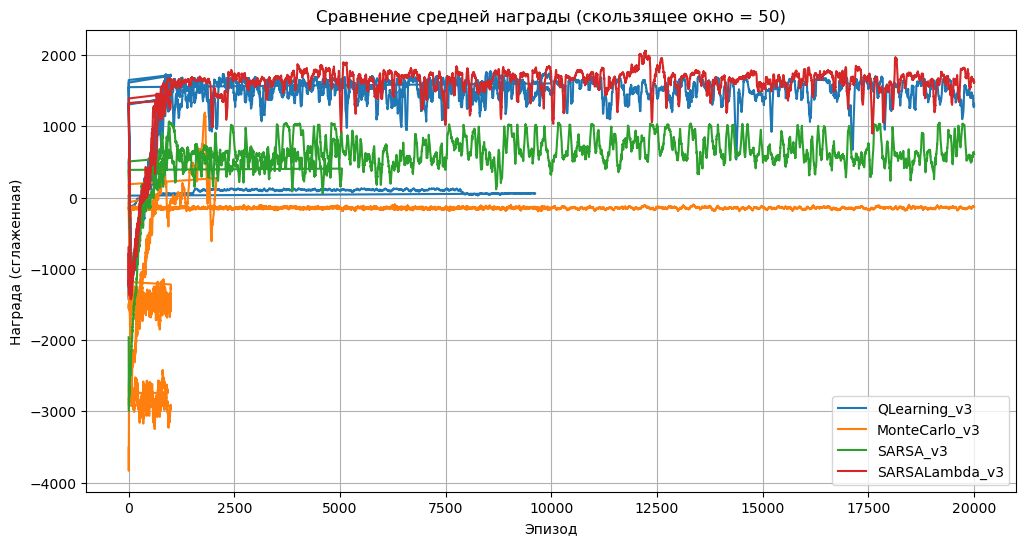

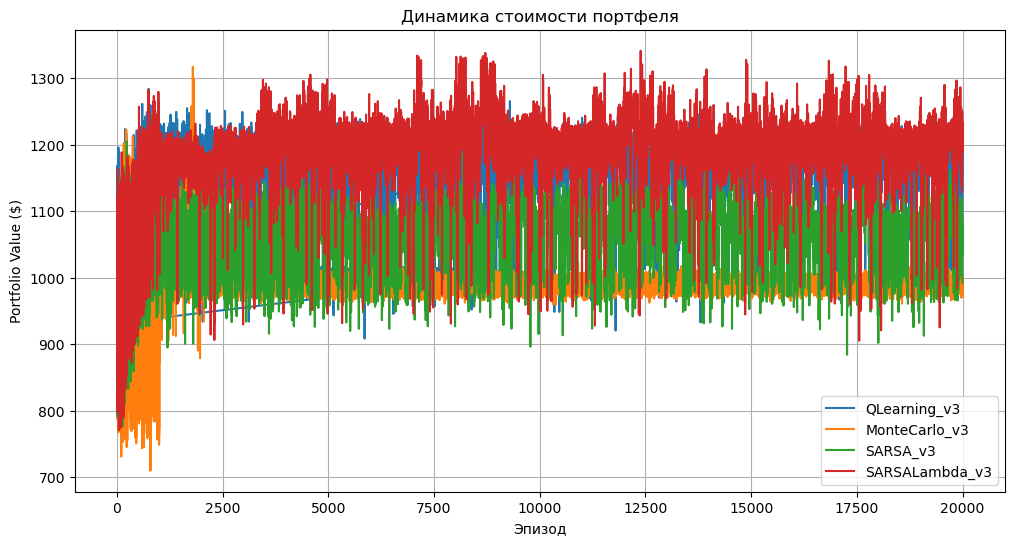

,agent,reward,portfolio_value,win_rate,n_trades,max_drawdown
43635,QLearning_v3,682.07,1087.44,46.15,52,0.02
84243,MonteCarlo_v3,-85.08,993.34,21.05,19,0.00
110291,SARSA_v3,-75.21,992.14,36.84,19,0.02
132333,SARSALambda_v3,1599.03,1206.71,40.91,22,0.02


In [3]:

import pandas as pd
import matplotlib.pyplot as plt
import json
from pathlib import Path

experiment_dirs = [
    f"../training_data/logs/exp_qlearn_{TRAIN_VERSION}",
    f"../training_data/logs/exp_monte_carlo_{TRAIN_VERSION}",
    f"../training_data/logs/exp_sarsa_{TRAIN_VERSION}",
    f"../training_data/logs/exp_sarsa_lambda_{TRAIN_VERSION}",
]

all_data = []
for exp_dir in experiment_dirs:
    exp_dir = Path(exp_dir)
    episodes_df = pd.read_csv(exp_dir / "episodes.csv")
    with open(exp_dir / "training_summary.json") as f:
        summary = json.load(f)
    agent_name = summary["config"]["agent_name"]
    episodes_df["agent"] = agent_name
    all_data.append(episodes_df)


df = pd.concat(all_data, ignore_index=True)

plt.figure(figsize=(12, 6))
for agent in df["agent"].unique():
    agent_data = df[df["agent"] == agent]
    smoothed = agent_data["reward"].rolling(window=50, min_periods=1).mean()
    plt.plot(agent_data["episode"], smoothed, label=agent)

plt.title("Сравнение средней награды (скользящее окно = 50)")
plt.xlabel("Эпизод")
plt.ylabel("Награда (сглаженная)")
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(12, 6))
for agent in df["agent"].unique():
    agent_data = df[df["agent"] == agent]
    plt.plot(agent_data["episode"], agent_data["portfolio_value"], label=agent)

plt.title("Динамика стоимости портфеля")
plt.xlabel("Эпизод")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True)
plt.show()


final_metrics = df.groupby("agent").tail(1)[
    ["agent", "reward", "portfolio_value", "win_rate", "n_trades", "max_drawdown"]
]
display(final_metrics.round(2))